In [117]:
!pip install unidecode

import pandas as pd
import unidecode
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import statsmodels.api as sm  
import pylab as pl  
from patsy import dmatrix 
from scipy import nanmean
from numpy import nanmean
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve


In [2]:
!unzip 'INFLUD-05-04-2021.zip'

!unzip 'merged_datasets_datasus_ibgenoticias_v5.zip'

Archive:  INFLUD-05-04-2021.zip
  inflating: INFLUD-05-04-2021.csv   
Archive:  merged_datasets_datasus_ibgenoticias_v5.zip
  inflating: merged_datasets_datasus_ibgenoticias_v5.csv  


In [3]:
df_main = pd.read_csv('INFLUD-05-04-2021.csv', sep=';')
df_main.head(2)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15,18,60,62,63,64,92,94,106,108,115,117,118,119,123) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,ID_UNIDADE,CO_UNI_NOT,CS_SEXO,DT_NASC,NU_IDADE_N,TP_IDADE,COD_IDADE,CS_GESTANT,CS_RACA,CS_ETINIA,CS_ESCOL_N,ID_PAIS,CO_PAIS,SG_UF,ID_RG_RESI,CO_RG_RESI,ID_MN_RESI,CO_MUN_RES,CS_ZONA,SURTO_SG,NOSOCOMIAL,AVE_SUINO,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,...,HISTO_VGM,PAIS_VGM,CO_PS_VGM,LO_PS_VGM,DT_VGM,DT_RT_VGM,PCR_SARS2,PAC_COCBO,PAC_DSCBO,OUT_ANIM,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,TOMO_RES,TOMO_OUT,DT_TOMO,TP_TES_AN,DT_RES_AN,RES_AN,POS_AN_FLU,TP_FLU_AN,POS_AN_OUT,AN_SARS2,AN_VSR,AN_PARA1,AN_PARA2,AN_PARA3,AN_ADENO,AN_OUTRO,DS_AN_OUT,TP_AM_SOR,SOR_OUT,DT_CO_SOR,TP_SOR,OUT_SOR,DT_RES,RES_IGG,RES_IGM,RES_IGA
0,14/01/2020,3,07/01/2020,2,SP,GVE I CAPITAL,1331.0,SAO PAULO,355030,HOSPITAL SAO LUIZ GONZAGA,2076896,F,27/04/2019,9,2,2009,6,4.0,NaN,5.0,BRASIL,1,SP,GVE I CAPITAL,1331.0,SAO PAULO,355030.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,9.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,28/01/2020,5,27/01/2020,5,SP,GVE I CAPITAL,1331.0,SAO PAULO,355030,HOSPITAL SAO CAMILO SANTANA,3039420,M,09/03/2019,10,2,2010,6,9.0,NaN,5.0,BRASIL,1,SP,GVE I CAPITAL,1331.0,SAO PAULO,355030.0,1.0,9.0,9.0,9.0,1.0,1.0,9.0,1.0,1.0,9.0,9.0,9.0,9.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_main.shape

(1189743, 154)

In [5]:
df_demais = pd.read_csv('merged_datasets_datasus_ibgenoticias_v5.csv', sep=',')
df_demais.head(2)

,ID_MN_RESI,SG_UF,DT_NOTIFIC,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,saidaSuspeitaObitos,saidaSuspeitaAltas,saidaConfirmadaObitos,saidaConfirmadaAltas,População Estimada (2019),Total de Enfermeiros,Enfermeiros do SUS,Enfermeiros a cada 100 mil habitantes,Enfermeiros do SUS a cada 100 mil habitantes,Total de médicos,Médicos do SUS,Médicos a cada 100 mil habitantes,Médicos do SUS a cada 100 mil habitantes,Total de Respiradores,Respiradores a cada 100 mil habitantes,Respiradores do SUS a cada 100 mil habitantes,Total de Respiradores do SUS,Total de Leitos de UTI,Leitos de UTI a cada 100 mil habitantes,Leitos de UTI do SUS,Leitos do SUS a cada 100 mil habitantes,Trabalhadores informais na unidade da Federação (julho 2019),Trabalhadores informais nas Regiões Metropolitas (julho 2019),Trabalhadores informais Capital (julho 2019),Trabalhadores informais no Interior (julho 2019)
0,ITAPEMA,SC,14/04/2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65312.0,36.0,35.0,55.120039,53.588927,63.0,33.0,96.460069,50.526703,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.000000,246144.9512,46269.2774,27553.9531,199875.6738
1,RIO DE JANEIRO,RJ,15/04/2020,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6718903.0,12921.0,9710.0,192.308179,144.517639,22073.0,13875.0,328.520891,206.506925,4253.0,63.299024,32.52019,2185.0,2587.0,38.503309,516.0,7.679825,400968.4169,283551.4756,178536.6888,117416.9413


In [6]:
df_demais.shape

(819947, 32)

In [7]:
df_demais = df_demais.rename(columns={'ID_MN_RESI':'ID_MUNICIP'})
df_demais = df_demais.rename(columns={'SG_UF': 'SG_UF_NOT'})
df_demais.head(2)

,ID_MUNICIP,SG_UF_NOT,DT_NOTIFIC,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,saidaSuspeitaObitos,saidaSuspeitaAltas,saidaConfirmadaObitos,saidaConfirmadaAltas,População Estimada (2019),Total de Enfermeiros,Enfermeiros do SUS,Enfermeiros a cada 100 mil habitantes,Enfermeiros do SUS a cada 100 mil habitantes,Total de médicos,Médicos do SUS,Médicos a cada 100 mil habitantes,Médicos do SUS a cada 100 mil habitantes,Total de Respiradores,Respiradores a cada 100 mil habitantes,Respiradores do SUS a cada 100 mil habitantes,Total de Respiradores do SUS,Total de Leitos de UTI,Leitos de UTI a cada 100 mil habitantes,Leitos de UTI do SUS,Leitos do SUS a cada 100 mil habitantes,Trabalhadores informais na unidade da Federação (julho 2019),Trabalhadores informais nas Regiões Metropolitas (julho 2019),Trabalhadores informais Capital (julho 2019),Trabalhadores informais no Interior (julho 2019)
0,ITAPEMA,SC,14/04/2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65312.0,36.0,35.0,55.120039,53.588927,63.0,33.0,96.460069,50.526703,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.000000,246144.9512,46269.2774,27553.9531,199875.6738
1,RIO DE JANEIRO,RJ,15/04/2020,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6718903.0,12921.0,9710.0,192.308179,144.517639,22073.0,13875.0,328.520891,206.506925,4253.0,63.299024,32.52019,2185.0,2587.0,38.503309,516.0,7.679825,400968.4169,283551.4756,178536.6888,117416.9413


In [8]:
df_demais['concat'] = df_demais['ID_MUNICIP'] + df_demais['SG_UF_NOT'] + df_demais['DT_NOTIFIC']
df_demais.head(2)

,ID_MUNICIP,SG_UF_NOT,DT_NOTIFIC,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,saidaSuspeitaObitos,saidaSuspeitaAltas,saidaConfirmadaObitos,saidaConfirmadaAltas,População Estimada (2019),Total de Enfermeiros,Enfermeiros do SUS,Enfermeiros a cada 100 mil habitantes,Enfermeiros do SUS a cada 100 mil habitantes,Total de médicos,Médicos do SUS,Médicos a cada 100 mil habitantes,Médicos do SUS a cada 100 mil habitantes,Total de Respiradores,Respiradores a cada 100 mil habitantes,Respiradores do SUS a cada 100 mil habitantes,Total de Respiradores do SUS,Total de Leitos de UTI,Leitos de UTI a cada 100 mil habitantes,Leitos de UTI do SUS,Leitos do SUS a cada 100 mil habitantes,Trabalhadores informais na unidade da Federação (julho 2019),Trabalhadores informais nas Regiões Metropolitas (julho 2019),Trabalhadores informais Capital (julho 2019),Trabalhadores informais no Interior (julho 2019),concat
0,ITAPEMA,SC,14/04/2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65312.0,36.0,35.0,55.120039,53.588927,63.0,33.0,96.460069,50.526703,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.000000,246144.9512,46269.2774,27553.9531,199875.6738,ITAPEMASC14/04/2020
1,RIO DE JANEIRO,RJ,15/04/2020,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6718903.0,12921.0,9710.0,192.308179,144.517639,22073.0,13875.0,328.520891,206.506925,4253.0,63.299024,32.52019,2185.0,2587.0,38.503309,516.0,7.679825,400968.4169,283551.4756,178536.6888,117416.9413,RIO DE JANEIRORJ15/04/2020


In [9]:
df_main['concat'] = df_main['ID_MUNICIP'] + df_main['SG_UF_NOT'] + df_main['DT_NOTIFIC']
df_main.head(2)

,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,ID_UNIDADE,CO_UNI_NOT,CS_SEXO,DT_NASC,NU_IDADE_N,TP_IDADE,COD_IDADE,CS_GESTANT,CS_RACA,CS_ETINIA,CS_ESCOL_N,ID_PAIS,CO_PAIS,SG_UF,ID_RG_RESI,CO_RG_RESI,ID_MN_RESI,CO_MUN_RES,CS_ZONA,SURTO_SG,NOSOCOMIAL,AVE_SUINO,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,...,PAIS_VGM,CO_PS_VGM,LO_PS_VGM,DT_VGM,DT_RT_VGM,PCR_SARS2,PAC_COCBO,PAC_DSCBO,OUT_ANIM,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,TOMO_RES,TOMO_OUT,DT_TOMO,TP_TES_AN,DT_RES_AN,RES_AN,POS_AN_FLU,TP_FLU_AN,POS_AN_OUT,AN_SARS2,AN_VSR,AN_PARA1,AN_PARA2,AN_PARA3,AN_ADENO,AN_OUTRO,DS_AN_OUT,TP_AM_SOR,SOR_OUT,DT_CO_SOR,TP_SOR,OUT_SOR,DT_RES,RES_IGG,RES_IGM,RES_IGA,concat
0,14/01/2020,3,07/01/2020,2,SP,GVE I CAPITAL,1331.0,SAO PAULO,355030,HOSPITAL SAO LUIZ GONZAGA,2076896,F,27/04/2019,9,2,2009,6,4.0,NaN,5.0,BRASIL,1,SP,GVE I CAPITAL,1331.0,SAO PAULO,355030.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAO PAULOSP14/01/2020
1,28/01/2020,5,27/01/2020,5,SP,GVE I CAPITAL,1331.0,SAO PAULO,355030,HOSPITAL SAO CAMILO SANTANA,3039420,M,09/03/2019,10,2,2010,6,9.0,NaN,5.0,BRASIL,1,SP,GVE I CAPITAL,1331.0,SAO PAULO,355030.0,1.0,9.0,9.0,9.0,1.0,1.0,9.0,1.0,1.0,9.0,9.0,9.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAO PAULOSP28/01/2020


In [10]:
df_demais= df_demais.drop_duplicates()

In [11]:
df_demais.shape

(794687, 33)

In [12]:
df = df_demais.drop_duplicates(subset='concat', keep='first')

In [13]:
df.shape

(500826, 33)

In [14]:
df_principal = df_main.merge(df, on = ['concat'], how='left')

In [15]:
df_principal.shape

(1189743, 187)

#Bases do PIB

In [16]:
df_pib = pd.read_excel('ibge_PIB_tabela_tratada.xlsx', sheet_name = 'Maiores PIB')
df_pib_per_capta = pd.read_excel('ibge_PIB_tabela_tratada.xlsx', sheet_name = 'Maiores PIB Per capta')

In [17]:
# Função para remover a acentuação
def remove_accentuation(df):
    return df.apply(lambda item: unidecode.unidecode(item))

# Função para deixar os termos em letra maiúscula 
def to_uppercase(df):
    return df.apply(lambda item: item.strip().upper())

In [18]:
df_pib['ID_MUNICIP'] = remove_accentuation(df_pib['Municípios '])
df_pib['ID_MUNICIP'] = to_uppercase(df_pib['ID_MUNICIP'])
#df_pib

In [19]:
df_pib_per_capta['ID_MUNICIP'] = remove_accentuation(df_pib_per_capta['Municípios'])
df_pib_per_capta['ID_MUNICIP'] = to_uppercase(df_pib_per_capta['ID_MUNICIP'])
#df_pib_per_capta

In [20]:
df_principal['ID_MUNICIP'] = df_principal['ID_MUNICIP_x']

In [21]:
df_principal_01 = df_principal.merge(df_pib, on = ['ID_MUNICIP'], how='left')

In [22]:
df_principal_v1 = df_principal_01.merge(df_pib_per_capta, on = ['ID_MUNICIP'], how='left')

In [23]:
df_principal_v1.shape

(1189743, 194)

# Eliminando variáveis com redundancia

In [24]:
df = pd.DataFrame(df_principal_v1, columns=['DT_NOTIFIC_x','SG_UF_NOT_x','ID_MUNICIP_x','CS_SEXO','DT_NASC','NU_IDADE_N','CS_GESTANT','CS_RACA','CS_ETINIA','CS_ESCOL_N','SG_UF','CO_MUN_RES','CS_ZONA','SURTO_SG','NOSOCOMIAL','AVE_SUINO','FEBRE','TOSSE','GARGANTA','DISPNEIA','DESC_RESP','SATURACAO','DIARREIA','VOMITO','OUTRO_SIN','OUTRO_DES','PUERPERA','FATOR_RISC','CARDIOPATI','HEMATOLOGI','SIND_DOWN','HEPATICA','ASMA','DIABETES','NEUROLOGIC','PNEUMOPATI','IMUNODEPRE','RENAL','OBESIDADE','OBES_IMC','OUT_MORBI','MORB_DESC','VACINA','DT_UT_DOSE','MAE_VAC','M_AMAMENTA','DT_DOSEUNI','DT_1_DOSE','DT_2_DOSE','ANTIVIRAL','TP_ANTIVIR','OUT_ANTIV','DT_ANTIVIR','HOSPITAL','UTI','SUPORT_VEN','RAIOX_RES','RAIOX_OUT','AMOSTRA','TP_AMOSTRA','DT_NOTIFIC_x','SG_UF_NOT_x','ID_MUNICIP_x''OUT_AMOST','PCR_RESUL','POS_PCRFLU','TP_FLU_PCR','PCR_FLUASU','FLUASU_OUT','PCR_FLUBLI','FLUBLI_OUT','POS_PCROUT','PCR_VSR','PCR_PARA1','PCR_PARA2','PCR_PARA3','PCR_PARA4','PCR_ADENO','PCR_METAP','PCR_BOCA','PCR_RINO','PCR_OUTRO','DS_PCR_OUT','CLASSI_FIN','CLASSI_OUT','CRITERIO','EVOLUCAO','HISTO_VGM','PAIS_VGM','CO_PS_VGM','LO_PS_VGM','PCR_SARS2','PAC_COCBO','PAC_DSCBO','OUT_ANIM','DOR_ABD','FADIGA','PERD_OLFT','PERD_PALA','TOMO_RES','TOMO_OUT','DT_TOMO','TP_TES_AN','RES_AN','POS_AN_FLU','TP_FLU_AN','POS_AN_OUT','AN_SARS2','AN_VSR','AN_PARA1','AN_PARA2','AN_PARA3','AN_ADENO','AN_OUTRO','DS_AN_OUT','TP_AM_SOR','SOR_OUT','DT_CO_SOR','TP_SOR','OUT_SOR','RES_IGG','RES_IGM','RES_IGA','concat','ocupacaoSuspeitoCli','ocupacaoSuspeitoUti','ocupacaoConfirmadoCli','ocupacaoConfirmadoUti','saidaSuspeitaObitos','saidaSuspeitaAltas','saidaConfirmadaObitos','saidaConfirmadaAltas','População Estimada (2019)','Total de Enfermeiros','Enfermeiros do SUS','Enfermeiros a cada 100 mil habitantes','Enfermeiros do SUS a cada 100 mil habitantes','Total de médicos','Médicos do SUS','Médicos a cada 100 mil habitantes','Médicos do SUS a cada 100 mil habitantes','Total de Respiradores','Respiradores a cada 100 mil habitantes','Respiradores do SUS a cada 100 mil habitantes','Total de Respiradores do SUS','Total de Leitos de UTI','Leitos de UTI a cada 100 mil habitantes','Leitos de UTI do SUS','Leitos do SUS a cada 100 mil habitantes','Trabalhadores informais na unidade da Federação (julho 2019)','Trabalhadores informais nas Regiões Metropolitas (julho 2019)','Trabalhadores informais Capital (julho 2019)','Trabalhadores informais no Interior (julho 2019)','ID_MUNICIP','Municípios ','Posição ocu- pada pelos 100 maiores municípios PIB','Flag_100_maiores_municipios_PIB','Municípios','Posição ocupada pelos 100 maiores municípios, o per capita','Flag_100_maiores_municipios_PIB_per_capta'])

In [25]:
df.shape

(1189743, 159)

# Variável Resposta

In [26]:
df.groupby(by='EVOLUCAO').size()

EVOLUCAO
1.0    696675
2.0    300504
3.0     13939
9.0     31028
dtype: int64

EVOLUÇÃO:
    1-Cura
    2-Obito
    3-Obito por outra causa
    4-Ignorado
    

In [27]:
df['resposta'] = np.where(df['EVOLUCAO']== 2.0,1,0)

In [28]:
df.groupby(by=['EVOLUCAO','resposta']).size()

EVOLUCAO  resposta
1.0       0           696675
2.0       1           300504
3.0       0            13939
9.0       0            31028
dtype: int64

# SELECIONANDO VARIAVEIS QUE FAZEM SENTIDO PARA PREDIÇÃO

In [29]:
df2 = df[['SG_UF_NOT_x','ID_MUNICIP_x','CS_SEXO','NU_IDADE_N','CS_GESTANT','CS_RACA','CS_ETINIA','CS_ESCOL_N','SURTO_SG','PUERPERA','FATOR_RISC','CARDIOPATI','HEMATOLOGI','SIND_DOWN','HEPATICA','ASMA','DIABETES','NEUROLOGIC','PNEUMOPATI','IMUNODEPRE','RENAL','OBESIDADE','OBES_IMC','OUT_MORBI','MORB_DESC','MAE_VAC','M_AMAMENTA','PAIS_VGM','ocupacaoSuspeitoCli','ocupacaoSuspeitoUti','ocupacaoConfirmadoCli','ocupacaoConfirmadoUti','saidaSuspeitaObitos','saidaSuspeitaAltas','saidaConfirmadaObitos','saidaConfirmadaAltas','População Estimada (2019)','Total de Enfermeiros','Enfermeiros do SUS','Enfermeiros a cada 100 mil habitantes','Enfermeiros do SUS a cada 100 mil habitantes','Total de médicos','Médicos do SUS','Médicos a cada 100 mil habitantes','Médicos do SUS a cada 100 mil habitantes','Total de Respiradores','Respiradores a cada 100 mil habitantes','Respiradores do SUS a cada 100 mil habitantes','Total de Respiradores do SUS','Total de Leitos de UTI','Leitos de UTI a cada 100 mil habitantes','Leitos de UTI do SUS','Leitos do SUS a cada 100 mil habitantes','Trabalhadores informais na unidade da Federação (julho 2019)','Trabalhadores informais nas Regiões Metropolitas (julho 2019)','Trabalhadores informais Capital (julho 2019)','Trabalhadores informais no Interior (julho 2019)','Flag_100_maiores_municipios_PIB','Flag_100_maiores_municipios_PIB_per_capta','resposta']]
df2.shape

(1189743, 61)

In [30]:
df_final=df2.copy()

In [31]:
def check_puerpera(item):
    if np.isnan(item):
        return 0;
    elif int(item) == 2:
        return 1;
    else: return 9;
df_final['PUERPERA'] = df2['PUERPERA'].apply(check_puerpera)

In [32]:
df_final.shape

(1189743, 61)

In [33]:
def check_sexo(item):
    if item == 'F':
        return 1;
    else: return 0;
df_final['CS_SEXO_F'] = df2['CS_SEXO'].apply(check_sexo)

In [34]:
def check_idade(item):
    if int(item)<= 0:
        return 0;
    elif int(item)<10:
        return 1;
    elif int(item)<20:
        return 2;
    elif int(item)<30:
        return 3;
    elif int(item)<40:
        return 4;
    elif int(item)<50:
        return 5;
    elif int(item)<60:
        return 6;
    elif int(item)<70:
        return 7;
    elif int(item)<80:
        return 8;
    elif int(item)<90:
        return 9;
    else: return 10;
df_final['NU_IDADE_N'] = df2['NU_IDADE_N'].apply(check_idade)

In [35]:
def check_FATOR_RISC(item):
    if item == 'S':
        return 1;
    else: return 0;
df_final['FATOR_RISC'] = df2['FATOR_RISC'].apply(check_FATOR_RISC)

In [36]:
def check_OBES_IMC(item):
    item = str(item).replace(",", ".")
    if pd.isnull(item):
        return 0;
    elif float(item)<= 17:
        return 1;
    elif float(item)<18.5:
        return 2;
    elif float(item)<25:
        return 3;
    elif float(item)<29.9:
        return 4;
    elif float(item)<34.9:
        return 5;
    elif float(item)<40:
        return 6;
    else: return 9;
    
df_final['OBES_IMC'] = df2['OBES_IMC'].apply(check_OBES_IMC)

In [37]:
def check_MORB_DESC(item):
    if pd.isnull(item):
        return 0;
    else: return 1;
df_final['MORB_DESC'] = df2['MORB_DESC'].apply(check_MORB_DESC)

In [38]:
def check_ocupacaoSuspeitoCli(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['ocupacaoSuspeitoCli'] = df2['ocupacaoSuspeitoCli'].apply(check_ocupacaoSuspeitoCli)

In [39]:
def check_ocupacaoSuspeitoUti(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['ocupacaoSuspeitoUti'] = df2['ocupacaoSuspeitoUti'].apply(check_ocupacaoSuspeitoUti)

In [40]:
def check_ocupacaoConfirmadoCli(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['ocupacaoConfirmadoCli'] = df2['ocupacaoConfirmadoCli'].apply(check_ocupacaoConfirmadoCli)

In [41]:
def check_ocupacaoConfirmadoUti(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['ocupacaoConfirmadoUti'] = df2['ocupacaoConfirmadoUti'].apply(check_ocupacaoConfirmadoUti)

In [42]:
def check_saidaSuspeitaObitos(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['saidaSuspeitaObitos'] = df2['saidaSuspeitaObitos'].apply(check_saidaSuspeitaObitos)

In [43]:
def check_saidaSuspeitaAltas(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['saidaSuspeitaAltas'] = df2['saidaSuspeitaAltas'].apply(check_saidaSuspeitaAltas)

In [44]:
def check_saidaConfirmadaObitos(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['saidaConfirmadaObitos'] = df2['saidaConfirmadaObitos'].apply(check_saidaConfirmadaObitos)

In [45]:
def check_saidaConfirmadaAltas(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['saidaConfirmadaAltas'] = df2['saidaConfirmadaAltas'].apply(check_saidaConfirmadaAltas)

In [46]:
def check_pop(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['pop_2019'] = df2['População Estimada (2019)'].apply(check_pop)

In [47]:
def check_enf_total(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['enf_total'] = df2['Total de Enfermeiros'].apply(check_enf_total)

In [48]:
def check_enf_sus(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['enf_sus'] = df2['Enfermeiros do SUS'].apply(check_enf_sus)

In [49]:
def check_enf_100K(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['enf_100K'] = df2['Enfermeiros a cada 100 mil habitantes'].apply(check_enf_100K)

In [50]:
def check_enf_100K_sus(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['enf_100K_sus'] = df2['Enfermeiros do SUS a cada 100 mil habitantes'].apply(check_enf_100K_sus)

In [51]:
def check_medicos(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['medicos'] = df2['Total de médicos'].apply(check_medicos)

In [52]:
def check_medicos_sus(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['medicos_sus'] = df2['Médicos do SUS'].apply(check_medicos_sus)

In [53]:
def check_medicos_100K(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['medicos_100K'] = df2['Médicos a cada 100 mil habitantes'].apply(check_medicos_100K)

In [54]:
def check_medicos_100K_sus(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['medicos_100K_sus'] = df2['Médicos do SUS a cada 100 mil habitantes'].apply(check_medicos_100K_sus)

In [55]:
def check_respiradores(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['respiradores'] = df2['Total de Respiradores'].apply(check_respiradores)

In [56]:
def check_respiradores_100K(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['respiradores_100K'] = df2['Respiradores a cada 100 mil habitantes'].apply(check_respiradores_100K)

In [57]:
def check_respiradores_100K_sus(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['respiradores_100K_sus'] = df2['Respiradores do SUS a cada 100 mil habitantes'].apply(check_respiradores_100K_sus)

In [58]:
def check_respiradores_sus(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['respiradores_sus'] = df2['Total de Respiradores do SUS'].apply(check_respiradores_sus)

In [59]:
def check_leitos_uti(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['leitos_uti'] = df2['Total de Leitos de UTI'].apply(check_leitos_uti)

In [60]:
def check_leitos_uti_100K(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['leitos_uti_100K'] = df2['Leitos de UTI a cada 100 mil habitantes'].apply(check_leitos_uti_100K)

In [61]:
def check_leitos_uti_sus(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['leitos_uti_sus'] = df2['Leitos de UTI do SUS'].apply(check_leitos_uti_sus)

In [62]:
def check_leitos_uti_sus_100K(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['leitos_uti_sus_100K'] = df2['Leitos do SUS a cada 100 mil habitantes'].apply(check_leitos_uti_sus_100K)

In [63]:
def check_trabalhadores_informais(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['trabalhadores_informais'] = df2['Trabalhadores informais na unidade da Federação (julho 2019)'].apply(check_trabalhadores_informais)

In [66]:
def check_trabalhadores_informais_metrop(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['trabalhadores_informais_metrop'] = df2['Trabalhadores informais nas Regiões Metropolitas (julho 2019)'].apply(check_trabalhadores_informais_metrop)

In [64]:
def check_trabalhadores_informais_capital(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['trabalhadores_informais_capital'] = df2['Trabalhadores informais Capital (julho 2019)'].apply(check_trabalhadores_informais_capital)

In [65]:
def check_trabalhadores_informais_interior(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['trabalhadores_informais_interior'] = df2['Trabalhadores informais no Interior (julho 2019)'].apply(check_trabalhadores_informais_interior)

In [67]:
def check_Flag_100_maiores_municipios_PIB(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['Flag_100_maiores_municipios_PIB'] = df2['Flag_100_maiores_municipios_PIB'].apply(check_Flag_100_maiores_municipios_PIB)

In [68]:
def check_Flag_100_maiores_municipios_PIB_per_capta(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final['Flag_100_maiores_municipios_PIB_per_capta'] = df2['Flag_100_maiores_municipios_PIB_per_capta'].apply(check_Flag_100_maiores_municipios_PIB_per_capta)

In [69]:
#Variáveis ja trabalhadas a serem mantidas
df = df_final[['SG_UF_NOT_x','ID_MUNICIP_x','NU_IDADE_N','CS_GESTANT','CS_RACA','CS_ETINIA','CS_ESCOL_N','SURTO_SG','PUERPERA','FATOR_RISC','CARDIOPATI','HEMATOLOGI','SIND_DOWN','HEPATICA','ASMA','DIABETES','NEUROLOGIC','PNEUMOPATI','IMUNODEPRE','RENAL','OBESIDADE','OBES_IMC','OUT_MORBI','MORB_DESC','MAE_VAC','M_AMAMENTA','Flag_100_maiores_municipios_PIB','Flag_100_maiores_municipios_PIB_per_capta','resposta','CS_SEXO_F','pop_2019','enf_total','enf_sus','enf_100K','enf_100K_sus','medicos','medicos_sus','medicos_100K','medicos_100K_sus','respiradores','respiradores_100K','respiradores_100K_sus','respiradores_sus','leitos_uti','leitos_uti_100K','leitos_uti_sus','leitos_uti_sus_100K','trabalhadores_informais','trabalhadores_informais_metrop','trabalhadores_informais_capital','trabalhadores_informais_interior']]
df.shape

(1189743, 52)

In [70]:
df_final2=df.copy()

In [71]:
df_final2.shape

(1189743, 52)

In [72]:
def check_MAE_VAC(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final2['MAE_VAC'] = df['MAE_VAC'].apply(check_MAE_VAC)

In [73]:
def check_M_AMAMENTA(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final2['M_AMAMENTA'] = df['M_AMAMENTA'].apply(check_M_AMAMENTA)

In [74]:
def check_OUT_MORBI(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final2['OUT_MORBI'] = df['OUT_MORBI'].apply(check_OUT_MORBI)

In [75]:
def check_CARDIOPATI(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final2['CARDIOPATI'] = df['CARDIOPATI'].apply(check_CARDIOPATI)

In [76]:
def check_HEMATOLOGI(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final2['HEMATOLOGI'] = df['HEMATOLOGI'].apply(check_HEMATOLOGI)

In [77]:
def check_SIND_DOWN(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final2['SIND_DOWN'] = df['SIND_DOWN'].apply(check_SIND_DOWN)

In [78]:
def check_HEPATICA(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final2['HEPATICA'] = df['HEPATICA'].apply(check_HEPATICA)

In [79]:
def check_ASMA(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final2['ASMA'] = df['ASMA'].apply(check_ASMA)

In [80]:
def check_DIABETES(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final2['DIABETES'] = df['DIABETES'].apply(check_DIABETES)

In [81]:
def check_NEUROLOGIC(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final2['NEUROLOGIC'] = df['NEUROLOGIC'].apply(check_NEUROLOGIC)

In [82]:
def check_PNEUMOPATI(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final2['PNEUMOPATI'] = df['PNEUMOPATI'].apply(check_PNEUMOPATI)

In [83]:
def check_IMUNODEPRE(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final2['IMUNODEPRE'] = df['IMUNODEPRE'].apply(check_IMUNODEPRE)

In [84]:
def check_RENAL(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final2['RENAL'] = df['RENAL'].apply(check_RENAL)

In [85]:
def check_OBESIDADE(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final2['OBESIDADE'] = df['OBESIDADE'].apply(check_OBESIDADE)

In [86]:
def check_CS_RACA(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final2['CS_RACA'] = df['CS_RACA'].apply(check_CS_RACA)

In [87]:
def check_CS_ESCOL_N(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final2['CS_ESCOL_N'] = df['CS_ESCOL_N'].apply(check_CS_ESCOL_N)

In [88]:
def check_SURTO_SG(item):
    if pd.isnull(item):
        return 0;
    else: return int(item);
df_final2['SURTO_SG'] = df['SURTO_SG'].apply(check_SURTO_SG)

In [89]:
df_final2.shape

(1189743, 52)

In [90]:
df_base_modelada = df_final2[['SG_UF_NOT_x','ID_MUNICIP_x','NU_IDADE_N','CS_GESTANT','CS_RACA','CS_ESCOL_N','SURTO_SG','PUERPERA','FATOR_RISC','CARDIOPATI','HEMATOLOGI','SIND_DOWN','HEPATICA','ASMA','DIABETES','NEUROLOGIC','PNEUMOPATI','IMUNODEPRE','RENAL','OBESIDADE','OBES_IMC','OUT_MORBI','MORB_DESC','MAE_VAC','M_AMAMENTA','Flag_100_maiores_municipios_PIB','Flag_100_maiores_municipios_PIB_per_capta','resposta','CS_SEXO_F','pop_2019','enf_total','enf_sus','enf_100K','enf_100K_sus','medicos','medicos_sus','medicos_100K','medicos_100K_sus','respiradores','respiradores_100K','respiradores_100K_sus','respiradores_sus','leitos_uti','leitos_uti_100K','leitos_uti_sus','leitos_uti_sus_100K','trabalhadores_informais','trabalhadores_informais_metrop','trabalhadores_informais_capital','trabalhadores_informais_interior']]

In [91]:
df_base_modelada = df_base_modelada.iloc[:,1:52]

In [92]:
df_base_modelada.shape

(1189743, 50)

# CRIANDO DUMMYS

Retiramos a variavel municipio, devido ao custo de processamento

In [93]:
df_dummy = df_base_modelada[['SG_UF_NOT_x','NU_IDADE_N','CS_GESTANT','CS_RACA','CS_ESCOL_N','CARDIOPATI','HEMATOLOGI','SIND_DOWN','HEPATICA','ASMA','DIABETES','NEUROLOGIC','PNEUMOPATI','IMUNODEPRE','RENAL','OBESIDADE','OBES_IMC','OUT_MORBI','MORB_DESC','MAE_VAC','M_AMAMENTA']]
df_dummy.shape

(1189743, 21)

In [94]:
df_dummy_concat = df_dummy.astype(str).apply(lambda item : item.name + '_' + item)

In [95]:
df_dummy_final = pd.get_dummies(df_dummy_concat)

In [96]:
df_dummy_final.shape

(1189743, 125)

In [97]:
df_demais = df_base_modelada[['SURTO_SG','PUERPERA','FATOR_RISC','Flag_100_maiores_municipios_PIB','Flag_100_maiores_municipios_PIB_per_capta','CS_SEXO_F','pop_2019','enf_total','enf_sus','enf_100K','enf_100K_sus','medicos','medicos_sus','medicos_100K','medicos_100K_sus','respiradores','respiradores_100K','respiradores_100K_sus','respiradores_sus','leitos_uti','leitos_uti_100K','leitos_uti_sus','leitos_uti_sus_100K','trabalhadores_informais','trabalhadores_informais_metrop','trabalhadores_informais_capital','trabalhadores_informais_interior','resposta']]
df_demais.shape

(1189743, 28)

In [98]:
df_final = pd.concat([df_demais, df_dummy_final], axis=1)


In [99]:
df_final.shape

(1189743, 153)

#Separando amostra balanceada  pelo target para regressão logistica

In [100]:
#Resposta = 1
resposta_1 = df_final.loc[df_final['resposta']==1]
resposta_1.shape

(300504, 153)

In [101]:
#Resposta = 0
resposta_0 = df_final.loc[df_final['resposta']==0]
resposta_0.shape

(889239, 153)

In [102]:
resp_0 = resposta_0.sample(300504)

#Juntando dataframes de igual tamanho para respostas de obito e não obito, a fim de obtermos uma base 50%/50%

Devido as grandes dimensões da base, 1.189.743 linhas e 3.045, enfrentamos multiplos desafios de processamento e espaço com memória.
Por isso optamos pela amostra balanceada respeitando aleatoriedade

In [103]:
df_balanceamento=pd.concat([resposta_1,resp_0], ignore_index=True)
df_balanceamento.shape

(601008, 153)

In [104]:
X = df_balanceamento.drop(['resposta'], axis=1)

In [105]:
y= df_balanceamento['resposta']

In [106]:
df_balanceamento.to_csv('base_sql.csv')

Separando a base em 30% para teste e 70% para treino

In [107]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)

#Árvore de Decisão

In [108]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)

In [109]:
#clf.feature_importances_

In [110]:
for feature,importancia in zip(df_balanceamento.columns,clf.feature_importances_):
    print("{}:{}".format(feature, importancia))

SURTO_SG:0.07480139899621191
PUERPERA:0.005863079767387395
FATOR_RISC:0.03968055112593704
Flag_100_maiores_municipios_PIB:0.006041462012274449
Flag_100_maiores_municipios_PIB_per_capta:0.0029332388663344654
CS_SEXO_F:0.0187221260567421
pop_2019:0.011672066404699494
enf_total:0.009004713106745176
enf_sus:0.008829890876901107
enf_100K:0.014863852539725863
enf_100K_sus:0.014131381765898213
medicos:0.00944596832551462
medicos_sus:0.010402829472532547
medicos_100K:0.015904720267890898
medicos_100K_sus:0.013932084218236043
respiradores:0.008703628527642613
respiradores_100K:0.012798527816139237
respiradores_100K_sus:0.01232989903123137
respiradores_sus:0.00920612953585998
leitos_uti:0.007993416146494082
leitos_uti_100K:0.010919579150901651
leitos_uti_sus:0.007695357414492736
leitos_uti_sus_100K:0.010404211177863958
trabalhadores_informais:0.004583817967266198
trabalhadores_informais_metrop:0.006836970346654555
trabalhadores_informais_capital:0.0055639451337013476
trabalhadores_informais_inte

In [111]:
resultado = clf.predict(X_test)

In [ ]:
#print(metrics.classification_report(y_test,resultado))

              precision    recall  f1-score   support

           0       0.62      0.66      0.64     90164
           1       0.63      0.60      0.61     90139

    accuracy                           0.63    180303
   macro avg       0.63      0.63      0.63    180303
weighted avg       0.63      0.63      0.63    180303



In [113]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

y_pred=clf.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.6274770802482488
0.5934833978633001
[[59640 30524]
 [36643 53496]]


#Random Forest

In [118]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [121]:
y_pred=rfc.predict(X_test)

In [122]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

print(accuracy_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.6678868349389638
0.6836330556141071
[[58800 31364]
 [28517 61622]]


In [123]:
for feature,importancia in zip(df_balanceamento.columns,rfc.feature_importances_):
    print("{}:{}".format(feature, importancia))

SURTO_SG:0.08512522982652802
PUERPERA:0.005007840164306424
FATOR_RISC:0.01092506388225415
Flag_100_maiores_municipios_PIB:0.006315325536452226
Flag_100_maiores_municipios_PIB_per_capta:0.002625988648446745
CS_SEXO_F:0.026055755995169797
pop_2019:0.011449075792263858
enf_total:0.010982570640115295
enf_sus:0.010874288830935332
enf_100K:0.011364311881091353
enf_100K_sus:0.011212558981262334
medicos:0.011148855263905992
medicos_sus:0.011062470963101298
medicos_100K:0.012150196446821889
medicos_100K_sus:0.011378906721030386
respiradores:0.010057948503217878
respiradores_100K:0.010389975057206447
respiradores_100K_sus:0.010134072025118507
respiradores_sus:0.009978245150952266
leitos_uti:0.008452869689264291
leitos_uti_100K:0.008726322599978884
leitos_uti_sus:0.008264774115405847
leitos_uti_sus_100K:0.008133268999251158
trabalhadores_informais:0.006518718119420356
trabalhadores_informais_metrop:0.005982896164796652
trabalhadores_informais_capital:0.006302086022096745
trabalhadores_informais_i

Mesmo utilizando um algoritmo mais complexo, não obtivemos ganho na assertividade do modelo

Otimizando Parametros

In [124]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    "max_depth": [4, 5, 6],
    "max_features": ["auto", "sqrt"],
    "n_estimators": [20, 50, 100]
}

cf = RandomForestClassifier()
cf_cv = GridSearchCV(estimator=cf, param_grid=param_grid, cv=3)
cf_cv.fit(X_train, y_train)

cf_cv.best_params_

{'max_depth': 6, 'max_features': 'auto', 'n_estimators': 100}

In [125]:
rfc1=RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators= 50, max_depth=6)

In [126]:
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [127]:
y_pred=cf_cv.predict(X_test)

In [128]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

print(accuracy_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.6568498582940938
0.7776988872740989
[[48331 41833]
 [20038 70101]]


#Regressão Logistica

In [130]:
# instancia o classificador com nome logit
logit = LogisticRegression()

In [131]:
logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [132]:
# faz predicao e salva em y_pred
y_pred = logit.predict(X_test)

#MÉTRICAS DE DESEMPENHO

In [133]:
print(accuracy_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.5566684969190752
0.44635507383041745
[[60135 30029]
 [49905 40234]]


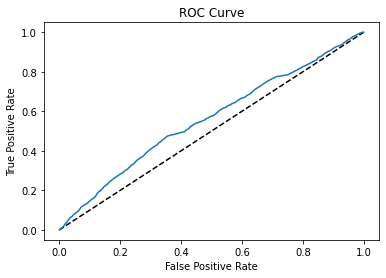

In [135]:
# computa probabilidades
y_pred_prob = logit.predict_proba(X_test)[:,1]

# Gera fpr, tpr e thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# curva ROC
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

#Aplicando Otimização aos hiperparâmetros da regressão

In [136]:
# Cria um conjunto de hiperparametros a serem testados
param_grid = {'C': np.logspace(-5, 8, 15), 'penalty': ['l1', 'l2']}

In [137]:
# Instancia a regressao logistica
logit = LogisticRegression()

In [138]:
from sklearn.model_selection import GridSearchCV

In [139]:
# Instancia GridSearchCV e ja faz um 5-fold cross validation 
logit_cv = GridSearchCV(logit, param_grid, cv=5)

In [140]:
GridSearchCV

sklearn.model_selection._search.GridSearchCV

In [141]:
# treina o modelo
logit_cv.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITER

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-05, 8.48342898e-05, 7.19685673e-04, 6.10540230e-03,
       5.17947468e-02, 4.39397056e-01, 3.72759372e+00, 3.16227766e+01,
       2.68269580e+02, 2.27584593e+03, 1.93069773e+04, 1.63789371e+05,
       1.38949549e+06, 1.17876863e+07, 1.00000000e+08]),
                         'penalty': ['l1', 'l2']},
 

In [142]:
# faz predicao e salva em y_pred
y_pred = logit_cv.predict(X_test)

In [143]:
print(accuracy_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.5566684969190752
0.44635507383041745
[[60135 30029]
 [49905 40234]]


#Próximos passos:
Redes Neurais                                                                                

Inclusão Variável Municipio